In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from tqdm import tqdm
from sklearn.datasets import fetch_lfw_people
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
data = fetch_lfw_people(min_faces_per_person=7, color=True)
data.images = np.transpose(data.images, (0,3,1,2))
data.images = torch.from_numpy(data.images).to(device)
data.target = torch.from_numpy(data.target).type(dtype=torch.int16)

In [26]:
data.images.shape

torch.Size([5095, 3, 62, 47])

In [104]:
def triplets(data, target, net, mode="beginning", margin=0.6):
  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  except_list = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  except_list = dict()
  for i in num_list:
    if i in except_list and except_list[i] < 3:
      except_list[i] += 1
    elif  i not in except_list: except_list[i] = 1
    else: continue
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    if mode =="end_pos":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = random.choice(negative)
    if mode == "end_neg":
      positive_final = random.choice(positive)
      negative_final = negative[torch.argmin(dist[i][negative])]
    if mode == "end":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = negative[torch.argmin(dist[i][negative])]
    if mode == "beginning":
      positive_final = random.choice(positive)
      negative_final = random.choice(negative)
    if mode == "semi-hard":
      positive_final = random.choice(positive)
      if ((dist[i][positive_final] <= dist[i][negative]).cpu() & (dist[i][negative] <= dist[i][positive_final] + margin).cpu()).sum() != 0:
        negative = negative[(dist[i][positive_final] <= dist[i][negative]).cpu() & (dist[i][negative] <= dist[i][positive_final] + margin).cpu()]
      negative_final = random.choice(negative)
    # plt.imshow(data[negative_final].permute(1,2,0).cpu())
    # plt.show()
    # plt.imshow(data[i].permute(1,2,0).cpu())
    # plt.show()
    # plt.imshow(data[positive_final].permute(1,2,0).cpu())
    # plt.show()
    triplets.append((embeddings[i],embeddings[positive_final],embeddings[negative_final]))
  return triplets

In [105]:
#acc 70-80 cant with hardtriplets
class Face_net_v1(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(7,7), padding=(3,3) ,stride=(2,2))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=(2,2) ,stride=(1,1))
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(7,7), padding=(3,3) ,stride=(2,2))
    self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=(2,2) ,stride=(1,1))
    self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1) ,stride=(1,1))
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(128, 128*4)
    self.linear2 = nn.Linear(128*4, 128)
  def forward(self, x):
    x = F.max_pool2d(self.conv1(x),(2,2))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(self.conv3(x),(2,2))
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(self.conv5(x), (2,2))
    x = F.relu(self.conv6(x))
    x = self.flat(x)
    x = F.relu(self.linear1(x))
    x = F.normalize(self.linear2(x))
    return x

In [106]:
class Face_net_v2(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5), padding=(2,2))
    self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3,3), padding=(1,1))
    self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3,3),padding=(1,1))
    self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3,3), padding=(1,1))
    self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3,3), padding=(1,1))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),padding=(1,1))
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),padding=(1,1))
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(12544, int(12544/4))
    self.linear2 = nn.Linear(int(12544/4), 128)
  def forward(self, x):
    x = F.max_pool2d(self.conv1(x),(2,2))
    x = F.relu(self.conv2a(x))
    x = F.max_pool2d(self.conv2(x),(2,2))
    x = F.relu(self.conv3a(x))
    x = F.max_pool2d(self.conv3(x),(2,2))
    x = F.relu(self.conv4a(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5a(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6a(x))
    x =  F.max_pool2d(self.conv6(x),(2,2))
    x = self.flat(x)
    x = F.relu(self.linear1(x))
    x = F.normalize(self.linear2(x))
    return x

In [107]:
def train_face_net(net, loss, data, optimizer, names,labels, test, epoch=5, mode="beginning", verbose=300, frequency=10, p_mode=True):
  for _ in range(epoch):
    if _ != 0: print("Current loss: ", l.item())
    labels = random.sample(labels, verbose)
    mask = []
    for i in labels:
      mask.extend(names[i])
    triplets_ = triplets(data.images[mask], data.target[mask], net, mode)
    l = torch.zeros(1, dtype = torch.float16).to(device)
    for triplet in triplets_:
      l += loss(triplet[0], triplet[1], triplet[2])
    l = l/len(triplets_)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if _ != 0 and _%frequency==0 or _==epoch-1:
      mask = []
      for i in test:
        mask.extend(names[i])
      dist, answer = accuracy(data.images[mask], data.target[mask], net)
      acc_list = []
      dansity = 400
      for threshold in np.linspace(0,2,dansity):
        correct = 0
        for i in range(len(answer)):
          if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
            correct += 1
        acc_list.append(correct/len(answer))
      if p_mode:
        plt.plot(np.linspace(0,2,dansity), acc_list)
        plt.title("tr-acc")
        plt.show()
      print("Max accuracy:", max(acc_list)," | " ,"Threshold: ", np.linspace(0,1,dansity)[np.array(acc_list).argmax()])

In [108]:
def accuracy(data, target, net):
  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  distances_slice = []
  answers = []
  except_list = []
  for i in num_list:
    if target[i] in except_list:
      continue
    else: except_list.append(target[i])
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    positive_final = random.choice(positive)
    negative_final = random.choice(negative)
    distances_slice.append(dist[i][positive_final].item())
    distances_slice.append(dist[i][negative_final].item())
    answers.append(1)
    answers.append(0)
  return distances_slice, answers

In [109]:
names = dict()
for i, label in enumerate(data.target):
  if label.item() in names:
    names[label.item()].append(i)
  else:
    names[label.item()] = [i]

net = Face_net_v1()
# net.load_state_dict(torch.load("model_v2"))
loss = nn.TripletMarginLoss(0.3)
net.to(device)

Face_net_v1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (conv5): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=128, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
)

In [110]:
all = list(names.keys())
train = all[0:int(len(all)*0.8)]
test = all[int(len(all)*0.8):]

In [111]:
optimizer = Adam(net.parameters(), lr=1e-3)

Current loss:  0.279052734375
Current loss:  0.274169921875
Current loss:  0.255615234375
Current loss:  0.2078857421875
Current loss:  0.167724609375
Current loss:  0.2230224609375
Current loss:  0.210693359375
Current loss:  0.1435546875
Current loss:  0.1617431640625
Current loss:  0.1500244140625


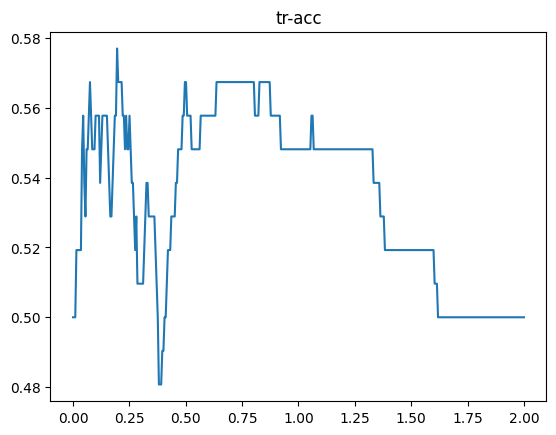

Max accuracy: 0.5769230769230769  |  Threshold:  0.09774436090225563
Current loss:  0.1075439453125
Current loss:  0.1463623046875
Current loss:  0.12646484375
Current loss:  0.10693359375
Current loss:  0.111328125
Current loss:  0.10107421875
Current loss:  0.12066650390625
Current loss:  0.1251220703125
Current loss:  0.10504150390625
Current loss:  0.0963134765625


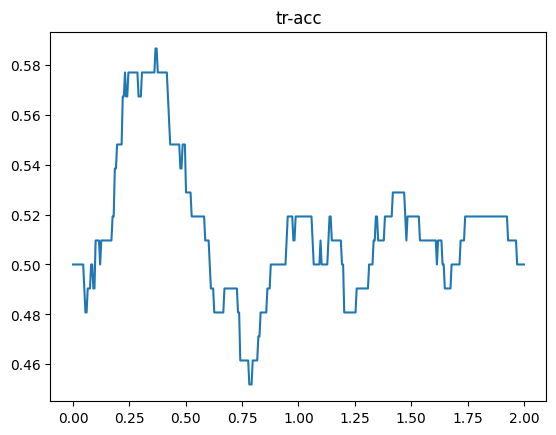

Max accuracy: 0.5865384615384616  |  Threshold:  0.18295739348370926
Current loss:  0.0994873046875
Current loss:  0.09185791015625
Current loss:  0.1002197265625
Current loss:  0.1234130859375
Current loss:  0.10614013671875
Current loss:  0.10516357421875
Current loss:  0.10076904296875
Current loss:  0.09564208984375
Current loss:  0.10107421875
Current loss:  0.1065673828125


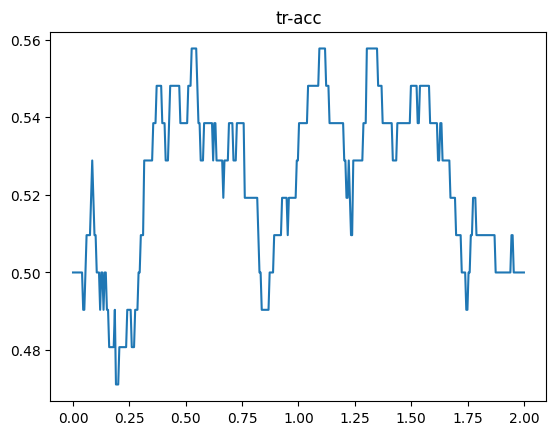

Max accuracy: 0.5576923076923077  |  Threshold:  0.2631578947368421
Current loss:  0.10052490234375
Current loss:  0.10174560546875
Current loss:  0.10504150390625
Current loss:  0.1021728515625
Current loss:  0.0963134765625
Current loss:  0.09979248046875
Current loss:  0.091552734375
Current loss:  0.09490966796875
Current loss:  0.09466552734375
Current loss:  0.0921630859375


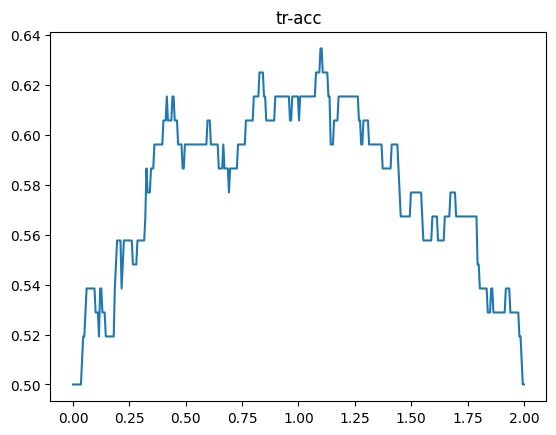

Max accuracy: 0.6346153846153846  |  Threshold:  0.5488721804511278
Current loss:  0.09027099609375
Current loss:  0.09124755859375
Current loss:  0.09197998046875
Current loss:  0.093505859375
Current loss:  0.09649658203125
Current loss:  0.10479736328125
Current loss:  0.0924072265625
Current loss:  0.09454345703125
Current loss:  0.08837890625
Current loss:  0.08740234375


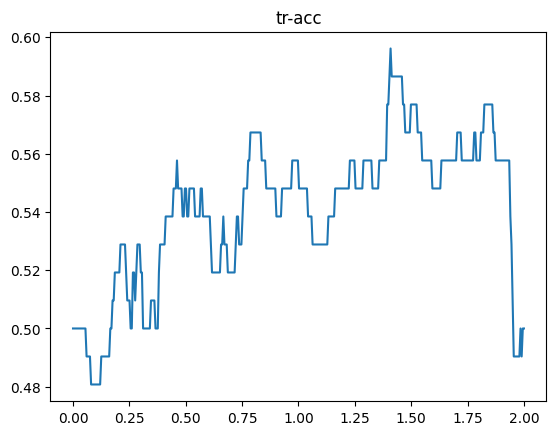

Max accuracy: 0.5961538461538461  |  Threshold:  0.7042606516290726
Current loss:  0.08673095703125
Current loss:  0.09600830078125
Current loss:  0.0859375
Current loss:  0.09710693359375
Current loss:  0.0994873046875
Current loss:  0.09393310546875
Current loss:  0.1094970703125
Current loss:  0.10205078125
Current loss:  0.087890625
Current loss:  0.0919189453125


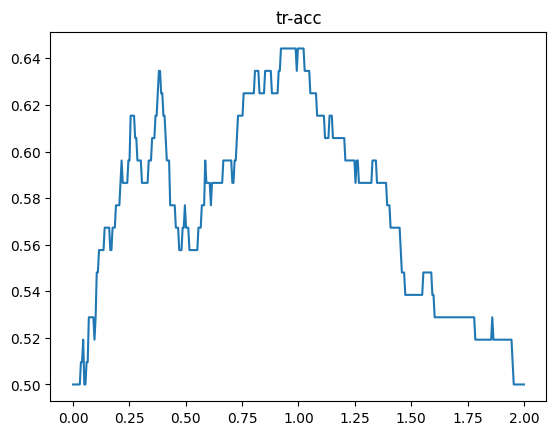

Max accuracy: 0.6442307692307693  |  Threshold:  0.46115288220551376
Current loss:  0.09844970703125
Current loss:  0.09033203125
Current loss:  0.09234619140625
Current loss:  0.0919189453125
Current loss:  0.084228515625
Current loss:  0.0848388671875
Current loss:  0.09564208984375
Current loss:  0.08892822265625
Current loss:  0.08868408203125
Current loss:  0.08843994140625


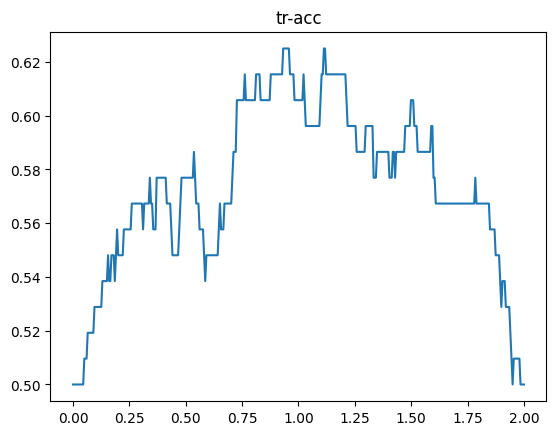

Max accuracy: 0.625  |  Threshold:  0.46616541353383456
Current loss:  0.0870361328125
Current loss:  0.09515380859375
Current loss:  0.098876953125
Current loss:  0.09173583984375
Current loss:  0.0811767578125
Current loss:  0.09002685546875
Current loss:  0.0859375
Current loss:  0.08795166015625
Current loss:  0.080078125
Current loss:  0.0926513671875


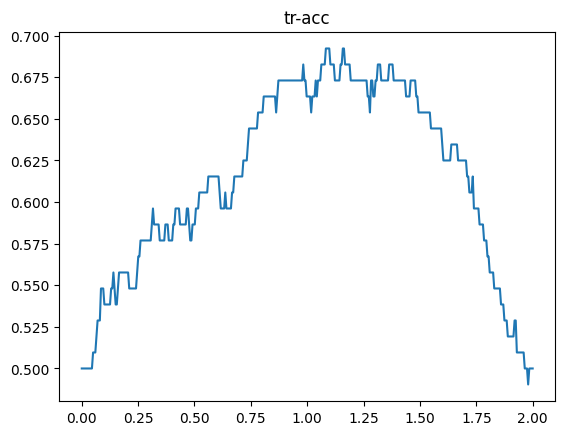

Max accuracy: 0.6923076923076923  |  Threshold:  0.5413533834586466
Current loss:  0.0933837890625
Current loss:  0.08892822265625
Current loss:  0.087158203125
Current loss:  0.08843994140625
Current loss:  0.0858154296875
Current loss:  0.0809326171875
Current loss:  0.083984375
Current loss:  0.0982666015625
Current loss:  0.09051513671875
Current loss:  0.089111328125


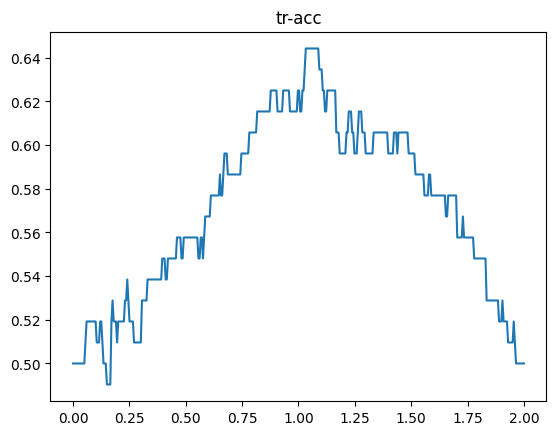

Max accuracy: 0.6442307692307693  |  Threshold:  0.5162907268170426
Current loss:  0.087646484375
Current loss:  0.08270263671875
Current loss:  0.08306884765625
Current loss:  0.08282470703125
Current loss:  0.0831298828125
Current loss:  0.0858154296875
Current loss:  0.08331298828125
Current loss:  0.07501220703125
Current loss:  0.0794677734375
Current loss:  0.0911865234375


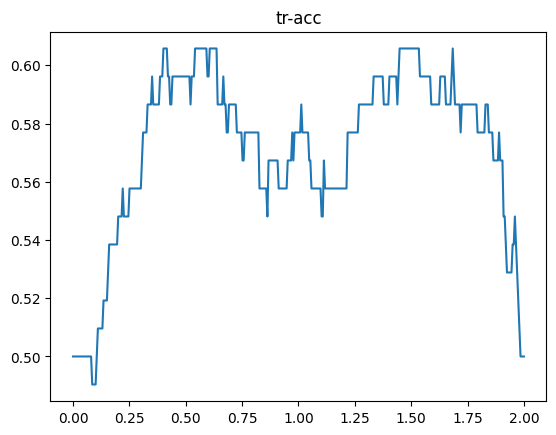

Max accuracy: 0.6057692307692307  |  Threshold:  0.20050125313283207
Current loss:  0.08270263671875
Current loss:  0.08087158203125
Current loss:  0.0919189453125
Current loss:  0.08074951171875
Current loss:  0.0797119140625
Current loss:  0.07818603515625
Current loss:  0.08453369140625
Current loss:  0.0809326171875
Current loss:  0.0810546875
Current loss:  0.0772705078125


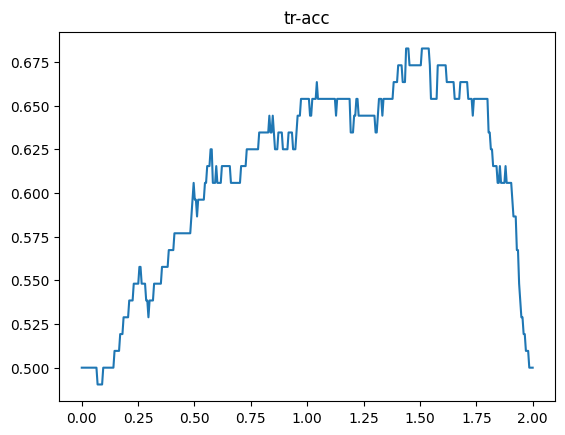

Max accuracy: 0.6826923076923077  |  Threshold:  0.7192982456140351
Current loss:  0.0792236328125
Current loss:  0.07843017578125
Current loss:  0.08062744140625
Current loss:  0.07421875
Current loss:  0.07696533203125
Current loss:  0.083740234375
Current loss:  0.0791015625
Current loss:  0.07611083984375
Current loss:  0.072998046875
Current loss:  0.080810546875


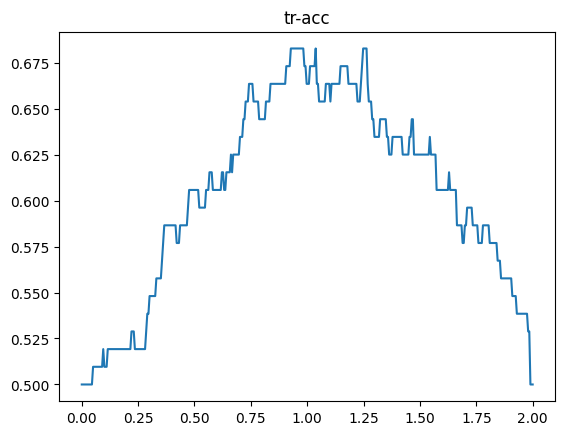

Max accuracy: 0.6826923076923077  |  Threshold:  0.46365914786967416
Current loss:  0.0765380859375
Current loss:  0.0723876953125
Current loss:  0.07415771484375
Current loss:  0.0799560546875
Current loss:  0.08306884765625
Current loss:  0.07489013671875
Current loss:  0.0689697265625
Current loss:  0.0703125
Current loss:  0.07672119140625
Current loss:  0.07647705078125


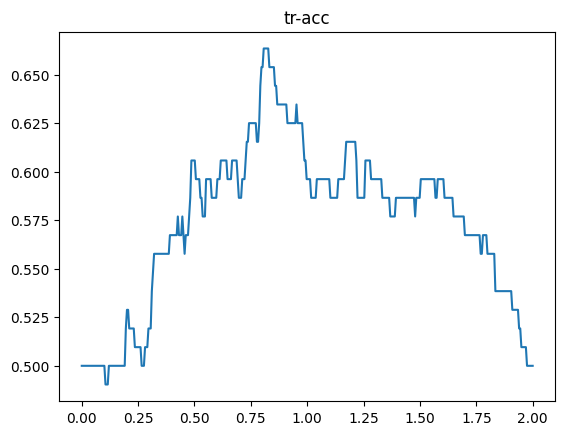

Max accuracy: 0.6634615384615384  |  Threshold:  0.40350877192982454
Current loss:  0.0706787109375
Current loss:  0.0723876953125
Current loss:  0.06829833984375
Current loss:  0.07373046875
Current loss:  0.06939697265625
Current loss:  0.06768798828125
Current loss:  0.07440185546875
Current loss:  0.0733642578125
Current loss:  0.0694580078125
Current loss:  0.0751953125


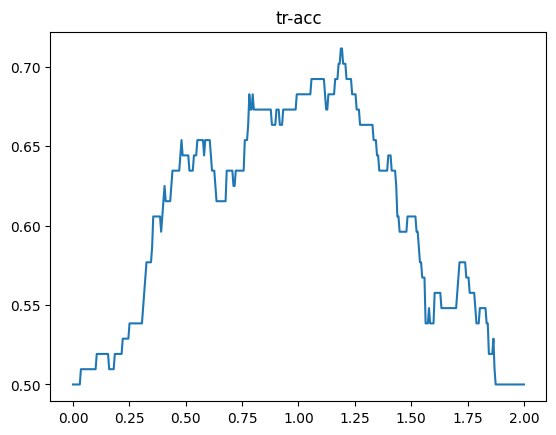

Max accuracy: 0.7115384615384616  |  Threshold:  0.593984962406015
Current loss:  0.06768798828125
Current loss:  0.06671142578125
Current loss:  0.06646728515625
Current loss:  0.074462890625
Current loss:  0.071044921875
Current loss:  0.07061767578125
Current loss:  0.057708740234375
Current loss:  0.069091796875
Current loss:  0.0723876953125
Current loss:  0.0679931640625


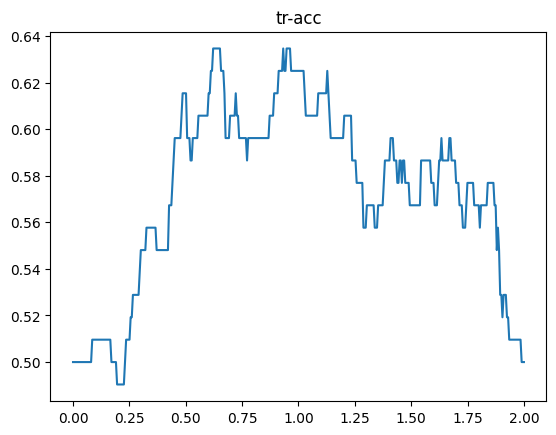

Max accuracy: 0.6346153846153846  |  Threshold:  0.3107769423558897
Current loss:  0.06298828125
Current loss:  0.07080078125
Current loss:  0.06365966796875
Current loss:  0.06793212890625
Current loss:  0.06451416015625
Current loss:  0.06866455078125
Current loss:  0.0675048828125
Current loss:  0.059600830078125
Current loss:  0.0615234375
Current loss:  0.06695556640625


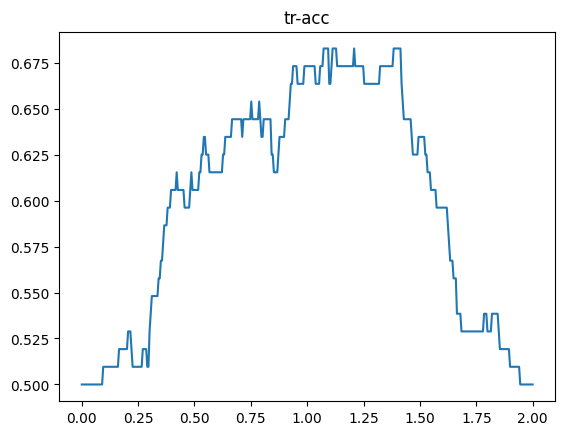

Max accuracy: 0.6826923076923077  |  Threshold:  0.5363408521303258
Current loss:  0.06390380859375
Current loss:  0.0677490234375
Current loss:  0.0576171875
Current loss:  0.065185546875
Current loss:  0.062286376953125
Current loss:  0.05908203125
Current loss:  0.06402587890625
Current loss:  0.0655517578125
Current loss:  0.05908203125
Current loss:  0.057586669921875


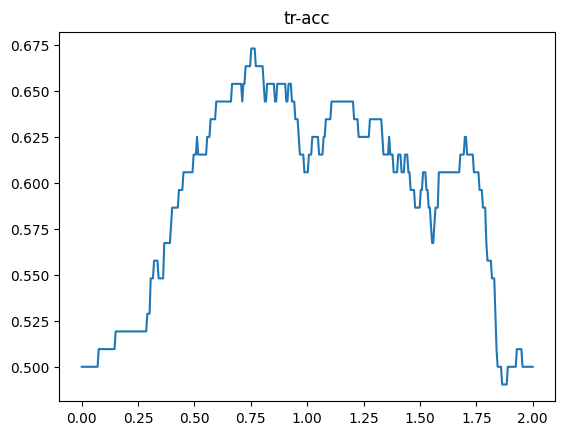

Max accuracy: 0.6730769230769231  |  Threshold:  0.37593984962406013
Current loss:  0.06475830078125
Current loss:  0.052093505859375
Current loss:  0.057159423828125
Current loss:  0.054779052734375
Current loss:  0.055694580078125
Current loss:  0.06158447265625
Current loss:  0.061065673828125
Current loss:  0.058380126953125
Current loss:  0.0584716796875
Current loss:  0.056060791015625


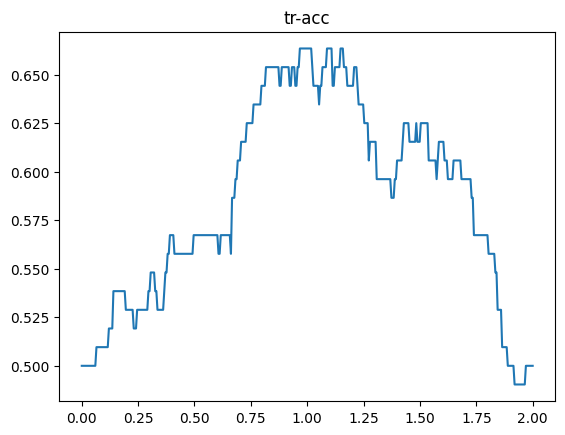

Max accuracy: 0.6634615384615384  |  Threshold:  0.48370927318295737
Current loss:  0.06304931640625
Current loss:  0.057952880859375
Current loss:  0.055145263671875
Current loss:  0.0546875
Current loss:  0.05084228515625
Current loss:  0.0538330078125
Current loss:  0.055755615234375
Current loss:  0.053009033203125
Current loss:  0.049774169921875
Current loss:  0.0501708984375


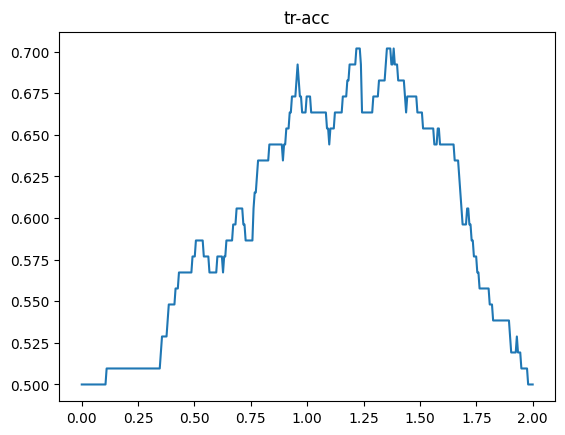

Max accuracy: 0.7019230769230769  |  Threshold:  0.6090225563909775
Current loss:  0.04974365234375
Current loss:  0.05413818359375
Current loss:  0.0501708984375
Current loss:  0.0484619140625
Current loss:  0.050018310546875
Current loss:  0.054595947265625
Current loss:  0.047576904296875
Current loss:  0.054473876953125
Current loss:  0.05328369140625
Current loss:  0.045684814453125


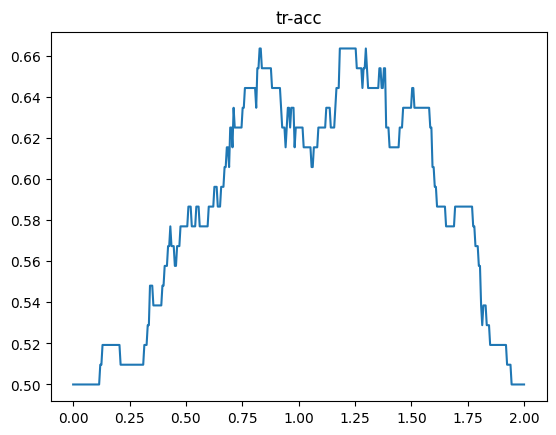

Max accuracy: 0.6634615384615384  |  Threshold:  0.41353383458646614
Current loss:  0.048065185546875
Current loss:  0.052032470703125
Current loss:  0.048309326171875
Current loss:  0.0479736328125
Current loss:  0.047271728515625
Current loss:  0.05133056640625
Current loss:  0.046661376953125
Current loss:  0.045318603515625
Current loss:  0.0484619140625
Current loss:  0.0489501953125


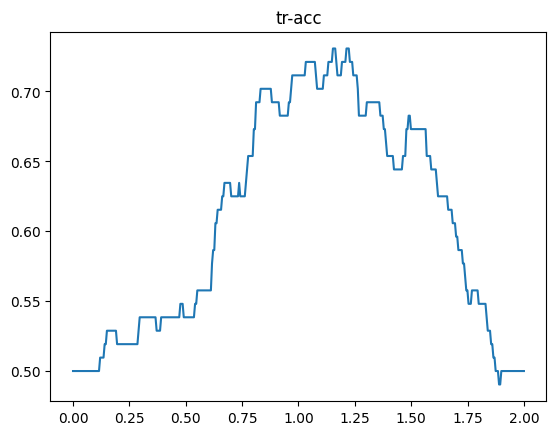

Max accuracy: 0.7307692307692307  |  Threshold:  0.5764411027568922
Current loss:  0.046173095703125
Current loss:  0.049041748046875
Current loss:  0.0496826171875
Current loss:  0.048309326171875
Current loss:  0.046478271484375
Current loss:  0.043670654296875
Current loss:  0.042694091796875
Current loss:  0.0399169921875
Current loss:  0.05023193359375
Current loss:  0.04766845703125


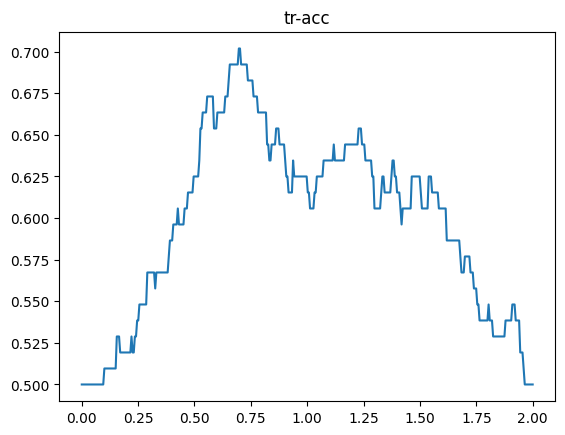

Max accuracy: 0.7019230769230769  |  Threshold:  0.3483709273182957
Current loss:  0.04437255859375
Current loss:  0.043548583984375
Current loss:  0.04302978515625
Current loss:  0.042022705078125
Current loss:  0.046112060546875
Current loss:  0.03668212890625
Current loss:  0.036407470703125
Current loss:  0.042236328125
Current loss:  0.037567138671875
Current loss:  0.04296875


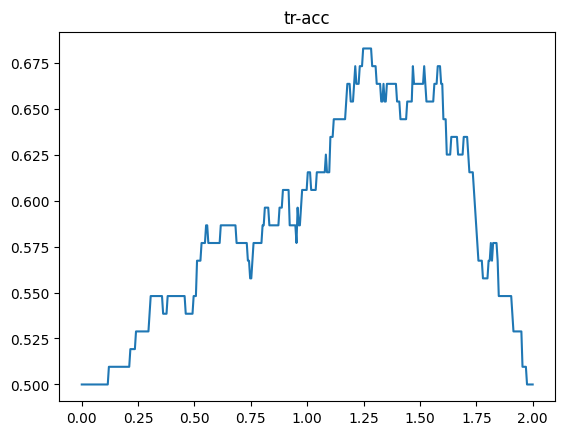

Max accuracy: 0.6826923076923077  |  Threshold:  0.6240601503759398
Current loss:  0.040374755859375
Current loss:  0.042999267578125
Current loss:  0.039581298828125
Current loss:  0.039276123046875
Current loss:  0.04058837890625
Current loss:  0.036956787109375
Current loss:  0.037078857421875
Current loss:  0.0360107421875
Current loss:  0.034332275390625
Current loss:  0.03607177734375


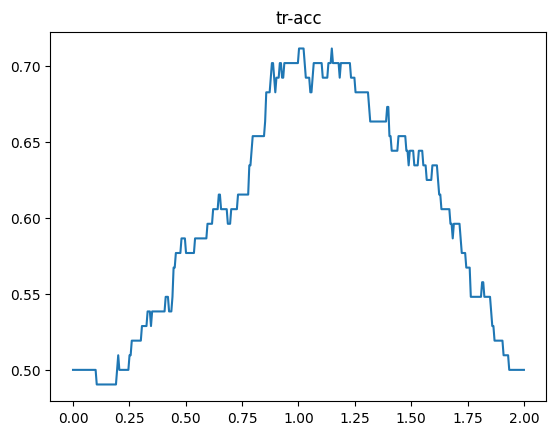

Max accuracy: 0.7115384615384616  |  Threshold:  0.5012531328320802
Current loss:  0.03765869140625
Current loss:  0.032867431640625
Current loss:  0.029510498046875
Current loss:  0.032806396484375
Current loss:  0.0335693359375
Current loss:  0.03179931640625
Current loss:  0.034210205078125
Current loss:  0.03765869140625
Current loss:  0.030517578125
Current loss:  0.032257080078125


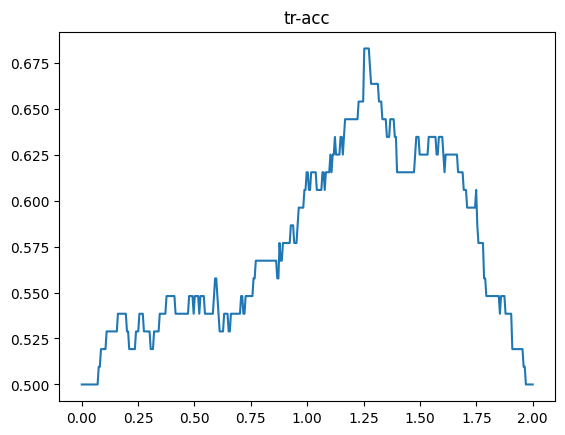

Max accuracy: 0.6826923076923077  |  Threshold:  0.6265664160401002
Current loss:  0.0325927734375
Current loss:  0.031097412109375
Current loss:  0.03045654296875
Current loss:  0.03021240234375
Current loss:  0.03485107421875
Current loss:  0.030670166015625
Current loss:  0.026885986328125
Current loss:  0.0289459228515625
Current loss:  0.0282135009765625
Current loss:  0.02532958984375


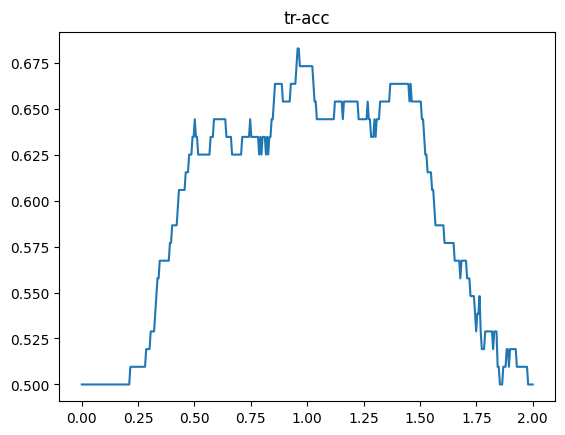

Max accuracy: 0.6826923076923077  |  Threshold:  0.47869674185463656
Current loss:  0.0274810791015625
Current loss:  0.0285186767578125
Current loss:  0.0261077880859375
Current loss:  0.026763916015625
Current loss:  0.028045654296875
Current loss:  0.0234527587890625
Current loss:  0.0253448486328125
Current loss:  0.022918701171875
Current loss:  0.0254974365234375
Current loss:  0.024566650390625


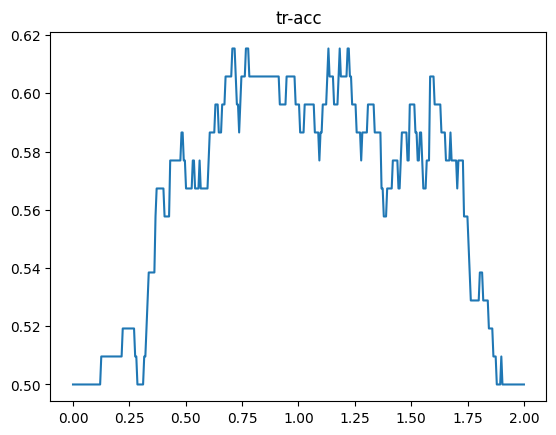

Max accuracy: 0.6153846153846154  |  Threshold:  0.3533834586466165
Current loss:  0.0229644775390625
Current loss:  0.022064208984375
Current loss:  0.02685546875
Current loss:  0.0234222412109375
Current loss:  0.02252197265625
Current loss:  0.0199432373046875
Current loss:  0.0171661376953125
Current loss:  0.021087646484375
Current loss:  0.0230560302734375
Current loss:  0.020355224609375


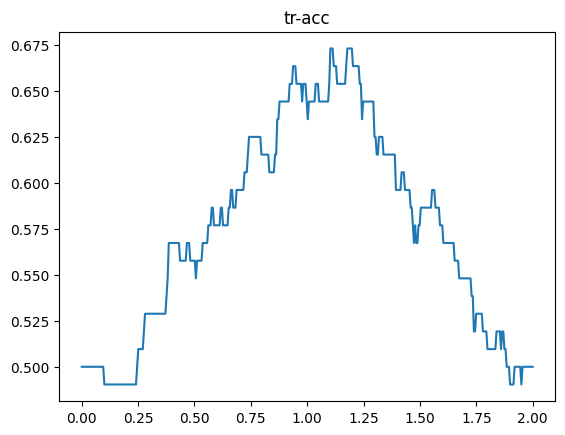

Max accuracy: 0.6730769230769231  |  Threshold:  0.5513784461152882
Current loss:  0.0193023681640625
Current loss:  0.02099609375
Current loss:  0.0216217041015625
Current loss:  0.02423095703125
Current loss:  0.017364501953125
Current loss:  0.0211029052734375
Current loss:  0.021026611328125
Current loss:  0.016510009765625
Current loss:  0.0232086181640625
Current loss:  0.01800537109375


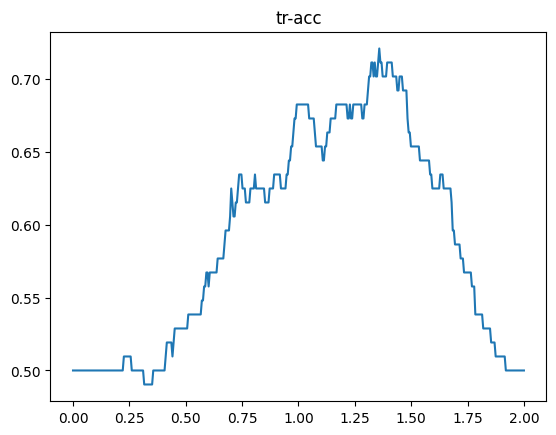

Max accuracy: 0.7211538461538461  |  Threshold:  0.6791979949874687
Current loss:  0.0186004638671875
Current loss:  0.01708984375
Current loss:  0.01526641845703125
Current loss:  0.01727294921875
Current loss:  0.0170440673828125
Current loss:  0.01503753662109375
Current loss:  0.01494598388671875
Current loss:  0.0161895751953125
Current loss:  0.0141448974609375


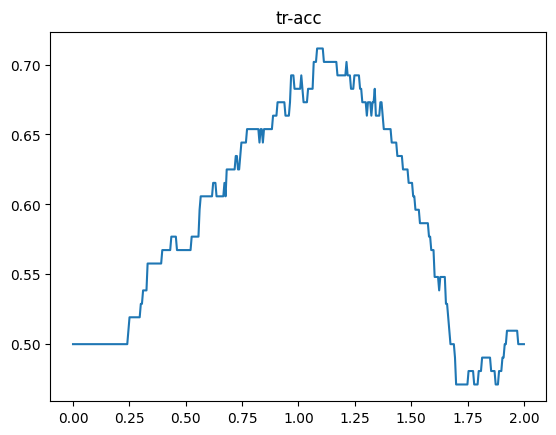

Max accuracy: 0.7115384615384616  |  Threshold:  0.5413533834586466


In [112]:
train_face_net(net, loss, data, optimizer, names, train, test, epoch=300, mode="semi-hard", verbose=50, frequency=10)

In [53]:
torch.save(net.state_dict(), "model_v2.1")

In [54]:
mask = []
for i in test:
  mask.extend(names[i])
dist, answer = accuracy(data.images[mask], data.target[mask], net)

In [55]:
acc_list = []
dansity = 400
for threshold in np.linspace(0,2,dansity):
  correct = 0
  for i in range(len(answer)):
    if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
      correct += 1
  acc_list.append(correct/len(answer))

Max accuracy: 0.5  |  Threshold:  0.0


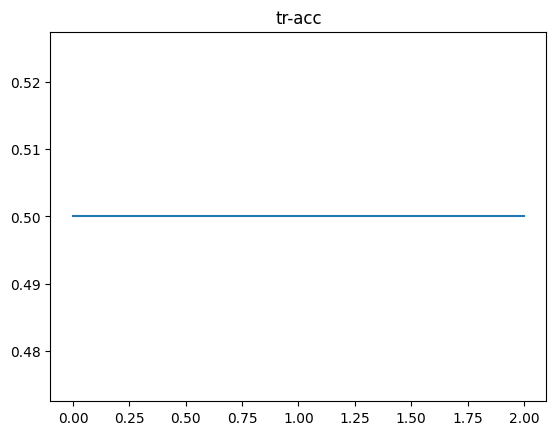

In [56]:
plt.plot(np.linspace(0,2,dansity), acc_list)
plt.title("tr-acc")
print("Max accuracy:", max(acc_list)," | " ,"Threshold: ", np.linspace(0,1,dansity)[np.array(acc_list).argmax()])
plt.show()